# Import Libraries

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Load Dataset

In [3]:
df = pd.read_csv("train.csv")
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


# Split Dataset to Train-Test

In [4]:
df_train, df_test = train_test_split(
    df,
    test_size=0.10,
    stratify=df["target"],
    random_state=0
)
df_train.shape, df_test.shape

((6851, 5), (762, 5))

# Bar plots with counts of target in train vs test

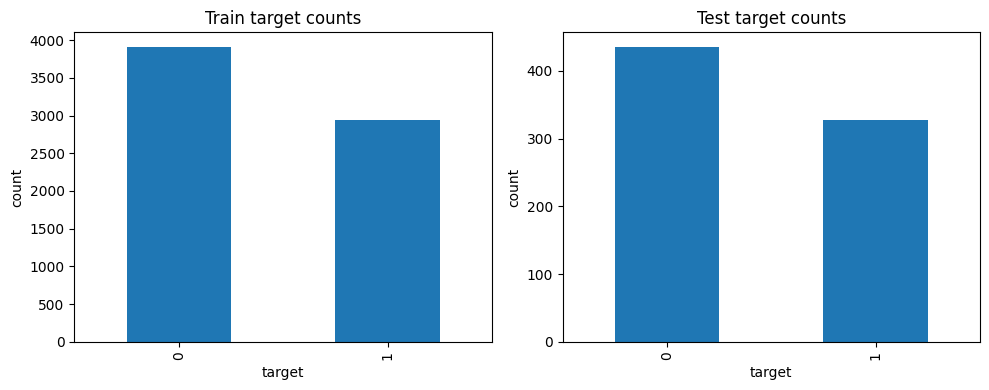

(np.float64(0.570281710699168), np.float64(0.5708661417322834))

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
df_train["target"].value_counts().sort_index().plot(kind="bar", ax=axes[0], title="Train target counts")
df_test["target"].value_counts().sort_index().plot(kind="bar", ax=axes[1], title="Test target counts")
for ax in axes:
    ax.set_xlabel("target")
    ax.set_ylabel("count")
plt.tight_layout()
plt.show()
df_train["target"].value_counts()[0]/df_train.shape[0],df_test["target"].value_counts()[0]/df_test.shape[0]

Από τα plots αλλά και από το ποσοστό της τιμης target 0 στο train dataset να ειναι ιδιο με το ποσοστό της τιμης target 0 στο test dataset προκύπτει ότι είναι ισορροπημένο το dataset. Αυτό συνεβεί εξαιτίας του stratify που χρησιμοποιήσαμε που έγινε με βάση την τιμή target.

# Drop Features(id and location)

In [6]:
df_train=df_train.drop(columns=["id", "location"])
df_test=df_test.drop(columns=["id", "location"])
df_train.shape, df_test.shape

((6851, 3), (762, 3))

# Fill in the missing values with the keyword “null”.

In [7]:
df_train[["keyword", "text"]] =df_train[["keyword", "text"]].fillna("null")
df_test[["keyword", "text"]] =df_test[["keyword", "text"]].fillna("null")
df_train

,keyword,text,target
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1
3940,flood,survived the plague\nfloated the flood\njust p...,0
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0
2234,deluge,Vince McMahon once again a billionaire: I reme...,0
4233,hazardous,Is it possible to sneak into a hospital so I c...,0
...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,0
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,1
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,1
3397,explode,If Ryan doesn't release new music soon I might...,0


# Merge the keyword and text columns

In [8]:
df_train["inputs"] = df_train["keyword"] + " " + df_train["text"]
df_test["inputs"] = df_test["keyword"] + " " + df_test["text"]
df_train

,keyword,text,target,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,threat Meek Mill responds to DrakeÛªs OVO Fes...
3940,flood,survived the plague\nfloated the flood\njust p...,0,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0,weapons #Kick Hendrixonfire @'=BLACKCATS= | B...
2234,deluge,Vince McMahon once again a billionaire: I reme...,0,deluge Vince McMahon once again a billionaire:...
4233,hazardous,Is it possible to sneak into a hospital so I c...,0,hazardous Is it possible to sneak into a hospi...
...,...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,0,flames @AWickedAssassin want to burst into fla...
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,1,trauma Photo: lavenderpoetrycafe: The Forgotte...
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,1,rescue Officials rescue 367 migrants off Libya...
3397,explode,If Ryan doesn't release new music soon I might...,0,explode If Ryan doesn't release new music soon...


# Ιmplemented functions for text processing

In [9]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','atUser',text)
    return text

def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\)'
<>:9: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\)'
/tmp/ipython-input-2025856900.py:9: SyntaxWarning: invalid escape sequence '\.'
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
/tmp/ipython-input-2025856900.py:15: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('@[^\s]+','atUser',text)
/tmp/ipython-input-2025856900.py:25: SyntaxWarning: invalid escape sequence '\)'
  text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)


# Description of the functions

**Remove Unicode:** Αφαιρεί μη αναγνώσιμα unicode σύμβολα, escape sequences και γενικό θόρυβο από το κείμενο.

**Replace URLs:** Αντικαθιστά τις διευθύνσεις URL με ένα κοινό token, αποφεύγοντας τη δημιουργία σπάνιων και μη γενικεύσιμων χαρακτηριστικών.Τα URLs είναι μοναδικά και δεν συμβάλλουν στη γενίκευση του μοντέλου για ανίχνευση φυσικών καταστροφών.

**ReplaceAtUser:** Αντικαθιστά τις αναφορές σε χρήστες του Twitter με την λέξη atUser, καθώς δεν σχετίζονται με το περιεχόμενο του συμβάντος.

**Remove Hashtag in Front of Word:** Αφαιρεί το σύμβολο # διατηρώντας τη λέξη του hashtag, η οποία συχνά περιέχει χρήσιμη σημασιολογική πληροφορία.

**Remove Emoticons:** Αφαιρεί ASCII emoticons (π.χ. :), :(, xD), τα οποία εκφράζουν συναίσθημα και όχι πληροφορία σχετική με το γεγονός.

**Replace Multiple Exclamation Marks:** Aντικαθιστά επαναλαμβανόμενα θαυμαστικά με  multiExclamation, μειώνοντας τη σπανιότητα των χαρακτηριστικών και διατηρώντας την πληροφορία έντασης.

**Replace Multiple Question Marks:** Αντικαθιστά επαναλαμβανόμενα ερωτηματικά με την λέξη MultiQuestion.

**Replace Multiple Stop Marks**: Αντικαθιστά επαναλαμβανόμενες τελείες με την λέξη MultiStop, περιορίζοντας τον θόρυβο από επαναλήψεις.


# Processing of tweet texts (inputs) in train

In [10]:
df_train["inputs"] = (
    df_train["inputs"]
        .apply(removeUnicode)
        .apply(replaceURL)
        .apply(replaceAtUser)
        .apply(removeHashtagInFrontOfWord)
        .apply(removeEmoticons)
        .apply(replaceMultiExclamationMark)
        .apply(replaceMultiQuestionMark)
        .apply(replaceMultiStopMark)
)
df_train

,keyword,text,target,inputs
6669,threat,Meek Mill responds to DrakeÛªs OVO Fest set w...,1,threat Meek Mill responds to Drakes OVO Fest s...
3940,flood,survived the plague\nfloated the flood\njust p...,0,flood survived the plague\nfloated the flood\n...
7217,weapons,#Kick Hendrixonfire @'=BLACKCATS= | BIG NOOB ...,0,weapons Kick Hendrixonfire atUser | BIG NOOB ...
2234,deluge,Vince McMahon once again a billionaire: I reme...,0,deluge Vince McMahon once again a billionaire ...
4233,hazardous,Is it possible to sneak into a hospital so I c...,0,hazardous Is it possible to sneak into a hospi...
...,...,...,...,...
3865,flames,@AWickedAssassin want to burst into flames! *A...,0,flames atUser want to burst into flames! *Anna...
6854,trauma,Photo: lavenderpoetrycafe: The Forgotten Histo...,1,trauma Photo lavenderpoetrycafe The Forgotten ...
5669,rescue,Officials rescue 367 migrants off Libya; 25 bo...,1,rescue Officials rescue 367 migrants off Libya...
3397,explode,If Ryan doesn't release new music soon I might...,0,explode If Ryan doesn't release new music soon...


# Processing of tweet texts (inputs) in test

In [11]:
df_test["inputs"] = (
    df_test["inputs"]
        .apply(removeUnicode)
        .apply(replaceURL)
        .apply(replaceAtUser)
        .apply(removeHashtagInFrontOfWord)
        .apply(removeEmoticons)
        .apply(replaceMultiExclamationMark)
        .apply(replaceMultiQuestionMark)
        .apply(replaceMultiStopMark)
)
df_test

,keyword,text,target,inputs
604,bioterror,#FedEx no longer to transport bioterror germs ...,1,bioterror FedEx no longer to transport bioterr...
5374,panic,Panic over: Patient in Alabama tests negative ...,1,panic Panic over Patient in Alabama tests nega...
3022,dust%20storm,New Mad Max Screenshots Show Off a Lovely Dust...,0,dust%20storm New Mad Max Screenshots Show Off ...
3357,evacuated,Rocky fire in Northern California swells to 60...,1,evacuated Rocky fire in Northern California sw...
4726,lava,@YoungHeroesID Lava Blast &amp; Power Red @die...,0,lava atUser Lava Blast &amp; Power Red atUser ...
...,...,...,...,...
5098,nuclear%20disaster,#refugees of #nuclear disaster in western #Jap...,1,nuclear%20disaster refugees of nuclear disaste...
525,avalanche,Musician Kalle Mattson Recreates 34 Classic Al...,0,avalanche Musician Kalle Mattson Recreates 34 ...
5169,obliterate,@Gargron good sir I did not wish to but now I ...,0,obliterate atUser good sir I did not wish to b...
3592,fatal,Man charged over fatal crash near Dubbo refuse...,1,fatal Man charged over fatal crash near Dubbo ...


# Split test and train datafames into to Numpy Arrays

In [12]:
x_train = df_train["inputs"].to_numpy()
y_train= df_train["target"].to_numpy()

x_test =df_test["inputs"].to_numpy()
y_test = df_test["target"].to_numpy()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((6851,), (6851,), (762,), (762,))

# Converting inputs to TF-IDF features

In [13]:
vectorizer = TfidfVectorizer()

x_train = vectorizer.fit_transform(x_train)
x_test  = vectorizer.transform(x_test)
x_train.shape,x_test.shape

((6851, 14251), (762, 14251))

# Create and Train Linear SVM

In [14]:
linear_svm = LinearSVC()
linear_svm.fit(x_train, y_train)

LinearSVC()

# Evaluate SVM on train set

In [15]:
y_train_pred = linear_svm.predict(x_train)

In [16]:
train_accuracy  = accuracy_score(y_train, y_train_pred)
train_f1        = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall    = recall_score(y_train, y_train_pred)
print(f"Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, "
      f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

Accuracy: 0.9639, F1: 0.9571, Precision: 0.9784, Recall: 0.9368


# Evaluate SVM on test set

In [17]:
y_test_pred  = linear_svm.predict(x_test)
test_accuracy  = accuracy_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall    = recall_score(y_test, y_test_pred)
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, "
      f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

Accuracy: 0.7966, F1: 0.7574, Precision: 0.7756, Recall: 0.7401


Η πιο σημαντική μετρική είναι το Recall καθώς είναι χρήσιμη μετρική όταν θέλουμε ο ταξινομητής μας να "πιάνει" όσο το δυνατόν περισσότερα θετικά παραδείγματα ακόμη και αν δεν είναι πολύ σίγουρος. Ένα false negative (μη ανίχνευση πραγματικής καταστροφής) είναι πολύ πιο επικίνδυνο από ένα false positive, καθώς μπορεί να οδηγήσει σε καθυστέρηση ή μη αποστολή προειδοποίησης. Επομένως, είναι κρίσιμο το μοντέλο να εντοπίζει όσο το δυνατόν περισσότερα πραγματικά περιστατικά φυσικών καταστροφών, ακόμη και αν αυτό οδηγεί σε μερικά ψευδώς θετικά.

# Conversion of components into a array

In [36]:
x_train_array=x_train.toarray()
x_test_array=x_test.toarray()
x_train_array.shape, x_test_array.shape

((6851, 14251), (762, 14251))

# Application of PCA to data

In [19]:

pca = PCA(n_components=0.95, random_state=0)

x_train_pca = pca.fit_transform(x_train_array)
x_test_pca  = pca.transform(x_test_array)

print("Αριθμός συνιστωσών που κρατήθηκαν:", pca.n_components_)
print("Συνολική διατηρούμενη πληροφορία:", pca.explained_variance_ratio_.sum())

Αριθμός συνιστωσών που κρατήθηκαν: 3811
Συνολική διατηρούμενη πληροφορία: 0.9500107418802199


# Training Linear SVM on PCA data

In [20]:
lin_svc_pca = LinearSVC()
lin_svc_pca.fit(x_train_pca, y_train)

LinearSVC()

# Evaluate Linear SVM on test set

In [21]:
y_pred_lin = lin_svc_pca.predict(x_test_pca)

lin_acc  = accuracy_score(y_test, y_pred_lin)
lin_f1   = f1_score(y_test, y_pred_lin)
lin_prec = precision_score(y_test, y_pred_lin)
lin_rec  = recall_score(y_test, y_pred_lin)
print("LinearSVC + PCA")
print(f"Accuracy: {lin_acc:.4f}, F1: {lin_f1:.4f}, "
      f"Precision: {lin_prec:.4f}, Recall: {lin_rec:.4f}")


LinearSVC + PCA
Accuracy: 0.8084, F1: 0.7719, Precision: 0.7891, Recall: 0.7554


# Training SVM with RBF kernel on PCA data

In [22]:
svc_rbf = SVC(kernel="rbf", gamma="scale")
svc_rbf.fit(x_train_pca, y_train)

SVC()

# Evaluate RBF SVM on test set

In [23]:
y_pred_rbf = svc_rbf.predict(x_test_pca)

rbf_acc  = accuracy_score(y_test, y_pred_rbf)
rbf_f1   = f1_score(y_test, y_pred_rbf)
rbf_prec = precision_score(y_test, y_pred_rbf)
rbf_rec  = recall_score(y_test, y_pred_rbf)

print("SVC (RBF) + PCA")
print(f"Accuracy: {rbf_acc:.4f}, F1: {rbf_f1:.4f}, "
      f"Precision: {rbf_prec:.4f}, Recall: {rbf_rec:.4f}")

SVC (RBF) + PCA
Accuracy: 0.8123, F1: 0.7734, Precision: 0.8026, Recall: 0.7462


Το SVM με RBF kernel παρουσίασε ελαφρώς καλύτερη  απόδοση ως προς το Accuracy και το F1-score. Ωστόσο, ο LinearSVC πέτυχε υψηλότερο Recall,το οποίο όπως είπαμε προηγουμένως είναι ιδιαίτερα σημαντικό για την ανίχνευση φυσικών καταστροφών σε σύστημα έγκαιρης προειδοποίησης. Συνεπώς, ο LinearSVC είναι καταλληλότερος για το συγκεκριμένο σενάριο χρήσης.Επίσης είναι γρηγορότεος από τον rbf kernel.Το ότι οι διαφορές είναι μικρές δείχνει ότι: το PCA διατηρεί αρκετή πληροφορία και οτι τα δεδομένα είναι σε μεγάλο βαθμό γραμμικά διαχωρίσιμα στο TF-IDF χώρο.


# Training SVM with parameter RBF kernel and gamma='auto' on PCA data

In [24]:
svc_rbf_auto = SVC(kernel="rbf", gamma="auto")
svc_rbf_auto.fit(x_train_pca, y_train)

SVC(gamma='auto')

# Evaluate RBF SVM with paramter gamma='auto' on test set

In [25]:

y_pred_auto = svc_rbf_auto.predict(x_test_pca)

auto_acc  = accuracy_score(y_test, y_pred_auto)
auto_f1   = f1_score(y_test, y_pred_auto)
auto_prec = precision_score(y_test, y_pred_auto)
auto_rec  = recall_score(y_test, y_pred_auto)

print("SVC (RBF) + PCA, gamma=auto")
print(f"Accuracy: {auto_acc:.4f}, F1: {auto_f1:.4f}, "
      f"Precision: {auto_prec:.4f}, Recall: {auto_rec:.4f}")

SVC (RBF) + PCA, gamma=auto
Accuracy: 0.5709, F1: 0.0000, Precision: 0.0000, Recall: 0.0000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Η τιμή του gamma='scale' είναι γ=1 / (n_features * X.var()) οπότε εξαρτάται από τον αριθμό χαρακτηριστικών,τη διακύμανση των δεδομένων.Ενώ η τιμή του gamma='auto' είναι 1/ n_feature και εξαρτάται μόνο από τον αριθμό χαρακτηριστικών

Ο SVM  με RBF με gamma='auto'προέβλεψε όλα τα δείγματα ως target = 0.Το μοντέλο κατέληξε να προβλέπει αποκλειστικά την πλειοψηφική κλάση, με αποτέλεσμα μηδενικό Recall και F1-score για την κλάση της φυσικής καταστροφής. Το αποτέλεσμα αυτό οφείλεται στην υπερβολικά μικρή τιμή της παραμέτρου γ λόγω των πολλών χαρακτηριστικών, η οποία προκαλεί έντονο underfitting.

# Collection of all metrics

In [28]:
results = pd.DataFrame({
    "accuracy":  [test_accuracy,  lin_acc,  rbf_acc,  auto_acc],
    "f1":        [test_f1,   lin_f1,   rbf_f1,   auto_f1],
    "precision": [test_precision, lin_prec, rbf_prec, auto_prec],
    "recall":    [test_recall,  lin_rec,  rbf_rec,  auto_rec],
}, index=[
    "LinearSVC",
    "LinearSVC + PCA",
    "SVC RBF + PCA (scale)",
    "SVC RBF + PCA (auto)"
])
results

,accuracy,f1,precision,recall
LinearSVC,0.796588,0.757433,0.775641,0.740061
LinearSVC + PCA,0.808399,0.771875,0.789137,0.755352
SVC RBF + PCA (scale),0.812336,0.773376,0.802632,0.746177
SVC RBF + PCA (auto),0.570866,0.000000,0.000000,0.000000


# Plots of metrics



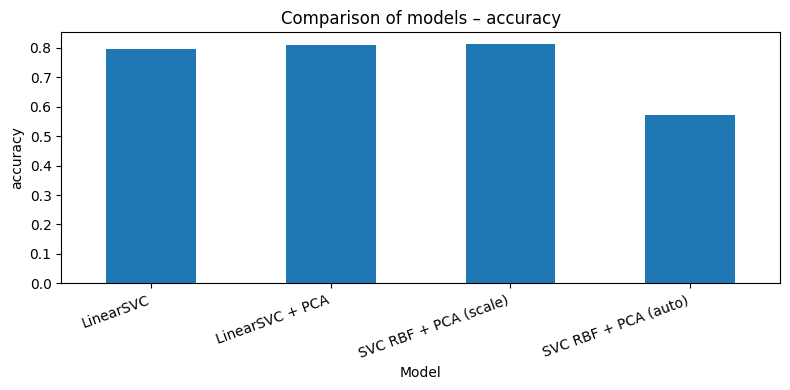

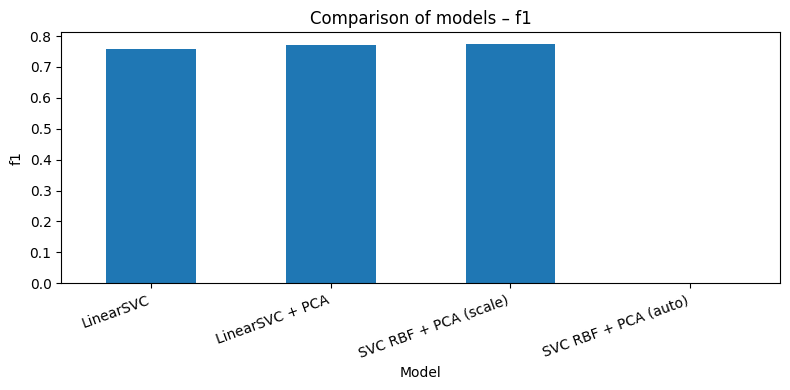

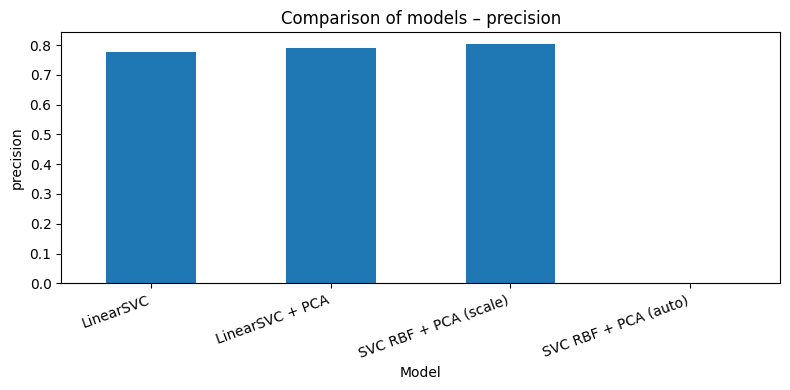

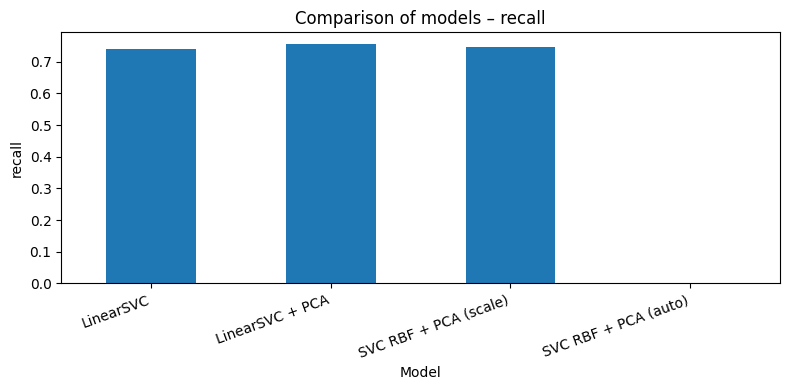

In [29]:


metrics = ["accuracy", "f1", "precision", "recall"]

for m in metrics:
    results[m].plot(kind="bar", figsize=(8, 4))
    plt.title(f"Comparison of models – {m}")
    plt.ylabel(m)
    plt.xlabel("Model")
    plt.xticks(rotation=20, ha="right")
    plt.tight_layout()
    plt.show()


# Train Gaussian Naive Bayes Model

In [33]:
gnb = GaussianNB()
gnb.fit(x_train_array, y_train)

GaussianNB()

# Evaluate Gaussian model on train set

In [34]:
y_train_pred = gnb.predict(x_train_array)
train_accuracy  = accuracy_score(y_train, y_train_pred)
train_f1        = f1_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall    = recall_score(y_train, y_train_pred)
print("Gaussian Naive Bayes – Train")
print(f"Accuracy: {train_accuracy:.4f}, F1: {train_f1:.4f}, "
      f"Precision: {train_precision:.4f}, Recall: {train_recall:.4f}")

Gaussian Naive Bayes – Train
Accuracy: 0.8840, F1: 0.8810, Precision: 0.7874, Recall: 1.0000


# Evaluate Gaussian model on test set

In [35]:
y_test_pred  = gnb.predict(x_test_array)
test_accuracy  = accuracy_score(y_test, y_test_pred)
test_f1        = f1_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall    = recall_score(y_test, y_test_pred)
print("\nGaussian Naive Bayes – Test")
print(f"Accuracy: {test_accuracy:.4f}, F1: {test_f1:.4f}, "
      f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")


Gaussian Naive Bayes – Test
Accuracy: 0.6207, F1: 0.6436, Precision: 0.5393, Recall: 0.7982


Ο Gaussian Naive Bayes εμφανίζει υψηλό Recall, δηλαδή εντοπίζει τις περισσότερες φυσικές καταστροφές, αλλά έχει χαμηλή συνολική απόδοση, καθώς παράγει αρκετές λανθασμένες προβλέψεις.